## Introduction

Domestic violence is a major public-safety issue in .
This project aims to predict whether a household that experienced a DV incident is likely to experience another one within the next 90 days**.
Such a model can help identify high-risk cases and support prevention efforts.

Using the Chicago Police Department’s open-data crime records, we:

* cleaned and prepared the dataset (dates, locations, categorical variables)
* engineered features related to time, location, and contextual risk
* trained several machine learning models (Random Forest, XGBoost, CatBoost)
* optimized them through hyperparameter tuning
* evaluated them using the F1-score, due to the strong class imbalance
* interpreted the results through feature importance and location patterns

This notebook walks through each step from understanding the data to training predictive models answering the key question :
Can we predict which households are most at risk of repeat domestic-violence incidents ?


In [1]:
import pandas as pd
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

### Get data from Kaggle

In [2]:
#%pip install kaggle

In [3]:
#kaggle datasets download -d chicago/chicago-crime


In [4]:
#%pip show kaggle

In [5]:
#from kaggle.api.kaggle_api_extended import KaggleApi

#api = KaggleApi()
#api.authenticate()
#print("✅ Authentication successful!")


In [6]:
#api.dataset_download_files('currie32/crimes-in-chicago', path='.', unzip=True)


In [7]:
df = pd.read_csv("Chicago_Crimes_2001_to_2004.csv", on_bad_lines='skip', low_memory=False)
df

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,879,4786321,HM399414,01/01/2004 12:01:00 AM,082XX S COLES AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,...,7.0,46.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,2544,4676906,HM278933,03/01/2003 12:00:00 AM,004XX W 42ND PL,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,11.0,61.0,26,1173974.0,1876757.0,2003.0,04/15/2016 08:55:02 AM,41.817229156,-87.637328,"(41.817229156, -87.637328162)"
2,2919,4789749,HM402220,06/20/2004 11:00:00 AM,025XX N KIMBALL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,...,35.0,22.0,20,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
3,2927,4789765,HM402058,12/30/2004 08:00:00 PM,045XX W MONTANA ST,0840,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,...,31.0,20.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
4,3302,4677901,HM275615,05/01/2003 01:00:00 AM,111XX S NORMAL AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,...,34.0,49.0,06,1174948.0,1831051.0,2003.0,04/15/2016 08:55:02 AM,41.691784636,-87.635116,"(41.691784636, -87.635115968)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923510,6252586,4781176,HM386461,04/01/2001 09:00:00 AM,023XX N LATROBE AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,ALLEY,False,...,37.0,19.0,06,1140960.0,1915056.0,2001.0,06/14/2006 04:14:16 AM,41.922996623,-87.757492,"(41.922996623, -87.757491503)"
1923511,6252606,4671197,HM270817,09/01/2003 12:01:00 AM,045XX N MOBILE AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,...,38.0,15.0,06,1133528.0,1929634.0,2003.0,04/15/2016 08:55:02 AM,41.963133955,-87.784457,"(41.963133955, -87.784456675)"
1923512,6252728,4671380,HM269330,08/01/2002 09:00:00 AM,020XX W 82ND PL,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,...,18.0,71.0,06,1164056.0,1849944.0,2002.0,04/15/2016 08:55:02 AM,41.743865444,-87.674464,"(41.743865444, -87.674463733)"
1923513,6253372,4782588,HM394550,06/04/2001 12:01:00 AM,087XX S MUSKEGON AVE,0610,BURGLARY,FORCIBLE ENTRY,OTHER,False,...,10.0,46.0,05,1196570.0,1847474.0,2001.0,07/05/2006 04:01:36 AM,41.736342659,-87.555413,"(41.736342659, -87.555413094)"


### Looking at columns

In [8]:
df.columns

Index(['Unnamed: 0', 'ID', 'Case Number', 'Date', 'Block', 'IUCR',
       'Primary Type', 'Description', 'Location Description', 'Arrest',
       'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code',
       'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')

In [9]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [10]:
display_all(df.head().T)

,0,1,2,3,4
Unnamed: 0,879,2544,2919,2927,3302
ID,4786321,4676906,4789749,4789765,4677901
Case Number,HM399414,HM278933,HM402220,HM402058,HM275615
Date,01/01/2004 12:01:00 AM,03/01/2003 12:00:00 AM,06/20/2004 11:00:00 AM,12/30/2004 08:00:00 PM,05/01/2003 01:00:00 AM
Block,082XX S COLES AVE,004XX W 42ND PL,025XX N KIMBALL AVE,045XX W MONTANA ST,111XX S NORMAL AVE
IUCR,0840,2825,1752,0840,0841
Primary Type,THEFT,OTHER OFFENSE,OFFENSE INVOLVING CHILDREN,THEFT,THEFT
Description,FINANCIAL ID THEFT: OVER $300,HARASSMENT BY TELEPHONE,AGG CRIM SEX ABUSE FAM MEMBER,FINANCIAL ID THEFT: OVER $300,FINANCIAL ID THEFT:$300 &UNDER
Location Description,RESIDENCE,RESIDENCE,RESIDENCE,OTHER,RESIDENCE
Arrest,False,False,False,False,False


In [11]:
display_all(df.describe(include = 'all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,1923515.0,NaN,NaN,NaN,4455517.18192,669267.580703,879.0,3931944.5,4475318.0,4957631.5,6254041.0
ID,1923515.0,NaN,NaN,NaN,2450313.732681,766289.835541,634.0,1819337.5,2414899.0,3017701.5,10813751.0
Case Number,1923515,1834167,HH257676,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,1923515,738075,01/01/2001 12:00:00 AM,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Block,1923515,55588,100XX W OHARE ST,6174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IUCR,1923515,360,0460,207796,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Primary Type,1923515,31,THEFT,395395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,1923515,339,SIMPLE,296808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location Description,1923499,144,STREET,584118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arrest,1923515,2,False,1354640,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.dtypes

Unnamed: 0                int64
ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate             object
Year                    float64
Updated On               object
Latitude                 object
Longitude               float64
Location                 object
dtype: object

### Date manipulation

In [13]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day
df["hour"] = df["Date"].dt.hour
df["dayofweek"] = df["Date"].dt.dayofweek

C:\Users\selin\AppData\Local\Temp\ipykernel_33236\1286522542.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


In [14]:
# Convert date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

In [15]:
df = df.dropna(subset=["Date"]).reset_index(drop=True)

### Fill missing values with the median

In [16]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

### Keep only domestic

In [17]:
df = df[df["Domestic"] == True].reset_index(drop=True)

### Build one unique key per household/address.

In [18]:
def make_block_key(row):
    block = row["Block"]

    if isinstance(block, str) and block.strip():
        return block.upper()

    if pd.notna(row["Latitude"]) and pd.notna(row["Longitude"]):
        return f"{round(row['Latitude'],3)}_{round(row['Longitude'],3)}"

    return f"D{row['District']}_C{row['Community Area']}"

df["block_key"] = df.apply(make_block_key, axis=1)


In [19]:
# Sort by household + time
df = df.sort_values(["Block", "Date"]).reset_index(drop=True)

# Next incident at the same block
next_date = df.groupby("Block")["Date"].shift(-1)

# Gap in days
gap_days = (next_date - df["Date"]).dt.days

# Label: 1 if next DV is within 90 days
df["y"] = ((gap_days.notna()) & (gap_days <= 90)).astype(int)


In [20]:
df[["Date", "Block", "y"]].head(20)

,Date,Block,y
0,2001-01-12 17:30:22,0000X E 100 PL,1
1,2001-01-12 17:30:22,0000X E 100 PL,0
2,2001-04-28 00:01:00,0000X E 100 PL,1
3,2001-07-19 18:20:00,0000X E 100 PL,1
4,2001-08-17 01:45:00,0000X E 100 PL,1
5,2001-09-24 08:00:00,0000X E 100 PL,0
6,2002-02-06 07:00:00,0000X E 100 PL,1
7,2002-02-07 18:00:00,0000X E 100 PL,1
8,2002-02-17 08:00:00,0000X E 100 PL,1
9,2002-02-19 08:00:00,0000X E 100 PL,1


### Create a sample

In [21]:
df_sample = df.sample(200000, random_state=42)

In [22]:
X = df_sample[[
    'Primary Type', 'Description', 'Location Description', 'Arrest',
    'IUCR', 'FBI Code',
    'Beat', 'District', 'Ward', 'Community Area',
    'X Coordinate', 'Y Coordinate',
    'Latitude', 'Longitude',
    'year', 'month', 'day', 'hour', 'dayofweek'
]]

y = df_sample['y']

In [23]:
#Numerical / Categorical Variables
cat_cols = ['Primary Type', 'Description', 'Location Description', 'IUCR', 'FBI Code']

num_cols = ['Arrest', 'Beat', 'District', 'Ward', 'Community Area','X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude','year', 'month', 'day', 'hour', 'dayofweek']

### Encode categorical variables

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
le = LabelEncoder()
X['Primary Type'] = le.fit_transform(X['Primary Type'])
X['Description'] = le.fit_transform(X['Description'])
X['Location Description'] = le.fit_transform(X['Location Description'])
X['IUCR'] = le.fit_transform(X['IUCR'])
X['FBI Code'] = le.fit_transform(X['FBI Code'])

C:\Users\selin\AppData\Local\Temp\ipykernel_33236\1068556348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Primary Type'] = le.fit_transform(X['Primary Type'])
C:\Users\selin\AppData\Local\Temp\ipykernel_33236\1068556348.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Description'] = le.fit_transform(X['Description'])
C:\Users\selin\AppData\Local\Temp\ipykernel_33236\1068556348.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

### Train/Test split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Features Engineering

In [27]:
X_train['is_weekend'] = (X_train['dayofweek'] >= 5).astype(int)
X_train['is_night'] = ((X_train['hour'] >= 20) | (X_train['hour'] <= 6)).astype(int)

X_test['is_weekend'] = (X_train['dayofweek'] >= 5).astype(int)
X_test['is_night'] = ((X_train['hour'] >= 20) | (X_train['hour'] <= 6)).astype(int)

In [28]:
# Month sin/cos (cyclical)
X_train['month_sin'] = np.sin(2 * np.pi * X_train['month'] / 12)
X_train['month_cos'] = np.cos(2 * np.pi * X_train['month'] / 12)

X_test['month_sin'] = np.sin(2 * np.pi * X_test['month'] / 12)
X_test['month_cos'] = np.cos(2 * np.pi * X_test['month'] / 12)

In [29]:
# Fix: convert to numeric
X_train["Latitude"] = pd.to_numeric(X_train["Latitude"], errors="coerce")
X_train["Longitude"] = pd.to_numeric(X_train["Longitude"], errors="coerce")

X_test["Latitude"] = pd.to_numeric(X_test["Latitude"], errors="coerce")
X_test["Longitude"] = pd.to_numeric(X_test["Longitude"], errors="coerce")


In [30]:
X_train['Latitude'] = X_train['Latitude'].astype(float)
X_test['Longitude'] = X_test['Longitude'].astype(float)

X_train['lat_lon_sum'] = X_train['Latitude'] + X_train['Longitude']
X_train['lat_lon_diff'] = X_train['Latitude'] - X_train['Longitude']

X_test['lat_lon_sum'] = X_test['Latitude'] + X_test['Longitude']
X_test['lat_lon_diff'] = X_test['Latitude'] - X_test['Longitude']

In [31]:
location_frequency = X['Location Description'].value_counts()
X['Location_freq'] = X['Location Description'].map(location_frequency)

C:\Users\selin\AppData\Local\Temp\ipykernel_33236\4199004265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Location_freq'] = X['Location Description'].map(location_frequency)


In [32]:
# Risk by District
district_risk = y_train.groupby(X_train['District']).mean()
X_train['district_risk'] = X_train['District'].map(district_risk)
X_test['district_risk'] = X_test['District'].map(district_risk)

# Risk by hour
hour_risk = y_train.groupby(X_train['hour']).mean()
X_train['hour_risk'] = X_train['hour'].map(hour_risk)
X_test['hour_risk'] = X_test['hour'].map(hour_risk)

### RandomForest

In [33]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [34]:
#F1 Score (Test set)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print("F1 :", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.45      0.52     14258
           1       0.73      0.84      0.79     25742

    accuracy                           0.70     40000
   macro avg       0.67      0.65      0.65     40000
weighted avg       0.69      0.70      0.69     40000

F1 : 0.785293586269196


In [35]:
#F1 Score (Train set)
y_pred = rf.predict(X_train)

print(classification_report(y_train, y_pred))
print("F1 :", f1_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     57553
           1       1.00      0.98      0.99    102447

    accuracy                           0.99    160000
   macro avg       0.98      0.99      0.99    160000
weighted avg       0.99      0.99      0.99    160000

F1 : 0.9898074411571206


In [36]:
rf_modified = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

rf_modified.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=10, min_samples_split=20,
                       n_estimators=200, random_state=42)

In [37]:
#F1 Score (Test set)
y_pred = rf_modified.predict(X_test)

print(classification_report(y_test, y_pred))
print("F1 :", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.60      0.58     14258
           1       0.77      0.73      0.75     25742

    accuracy                           0.69     40000
   macro avg       0.66      0.67      0.66     40000
weighted avg       0.69      0.69      0.69     40000

F1 : 0.7497563788954518


In [38]:
#F1 Score (Train set)
y_pred = rf_modified.predict(X_train)

print(classification_report(y_train, y_pred))
print("F1 :", f1_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.61      0.58     57553
           1       0.77      0.73      0.75    102447

    accuracy                           0.69    160000
   macro avg       0.67      0.67      0.67    160000
weighted avg       0.69      0.69      0.69    160000

F1 : 0.7513045907625994


### XGBoost

In [41]:
# Ensure all features are numeric for XGBoost
for col in X_train.columns:
    if X_train[col].dtype == "object" or str(X_train[col].dtype) == "category":
        X_train[col] = X_train[col].astype("category").cat.codes
        X_test[col] = X_test[col].astype("category").cat.codes

from xgboost import XGBClassifier

xg_model = XGBClassifier(
    tree_method="hist",
    eval_metric="aucpr",
    random_state=42
)

xg_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [46]:
#F1 score (test set)
y_pred = xg_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.49      0.54     14258
           1       0.74      0.83      0.78     25742

    accuracy                           0.71     40000
   macro avg       0.68      0.66      0.66     40000
weighted avg       0.70      0.71      0.70     40000

F1: 0.7830650804758572


In [47]:
#F1 score (train set)
y_pred = xg_model.predict(X_train)

print(classification_report(y_train, y_pred))
print("F1:", f1_score(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.52      0.60     57553
           1       0.76      0.88      0.82    102447

    accuracy                           0.75    160000
   macro avg       0.73      0.70      0.71    160000
weighted avg       0.74      0.75      0.74    160000

F1: 0.8167217760982523


### Optuna

In [48]:
X_optuna = X_train.sample(40000, random_state=42)
y_optuna = y_train.loc[X_optuna.index]

In [49]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "tree_method": "hist",
        "enable_categorical": True,
        "eval_metric": "logloss"
    }

    X_tr, X_val, y_tr, y_val = train_test_split(
        X_optuna, y_optuna, test_size=0.2, random_state=42
    )

    model = XGBClassifier(**params)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

In [50]:
study = optuna.create_study(study_name="xgb_opt", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-12-08 01:30:36,152] Using an existing study with name 'xgb_opt' instead of creating a new one.
[I 2025-12-08 01:30:41,774] Trial 20 finished with value: 0.7604205090372557 and parameters: {'max_depth': 9, 'learning_rate': 0.14424557717883504, 'n_estimators': 1200, 'subsample': 0.6891386364964055, 'colsample_bytree': 0.7117461752050265}. Best is trial 15 with value: 0.7879001675632772.
[I 2025-12-08 01:30:43,945] Trial 21 finished with value: 0.7914523851746763 and parameters: {'max_depth': 6, 'learning_rate': 0.015105181359376852, 'n_estimators': 859, 'subsample': 0.7430933457188145, 'colsample_bytree': 0.5036025558609675}. Best is trial 21 with value: 0.7914523851746763.
[I 2025-12-08 01:30:46,049] Trial 22 finished with value: 0.7914818101153505 and parameters: {'max_depth': 7, 'learning_rate': 0.012238372129628876, 'n_estimators': 672, 'subsample': 0.7426635437417004, 'colsample_bytree': 0.5458174664319229}. Best is trial 22 with value: 0.7914818101153505.
[I 2025-12-08 01:3

In [51]:
#get hyperparameters
study.best_params

{'max_depth': 3,
 'learning_rate': 0.07302045626901604,
 'n_estimators': 668,
 'subsample': 0.9489210127163299,
 'colsample_bytree': 0.568726722304199}

In [52]:
#Train final XGBoost on full dataset
best_params = study.best_params
best_params["tree_method"] = "hist"
best_params["enable_categorical"] = True
best_params["eval_metric"] = "logloss"

xgb_final = XGBClassifier(**best_params)
xgb_final.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.568726722304199, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07302045626901604,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=668, n_jobs=None,
              num_parallel_tree=None, ...)

In [53]:
#F1 score (test set)

y_pred = xgb_final.predict(X_test)
print(classification_report(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.46      0.53     14258
           1       0.74      0.86      0.79     25742

    accuracy                           0.71     40000
   macro avg       0.69      0.66      0.66     40000
weighted avg       0.70      0.71      0.70     40000

F1: 0.7933946804487584


In [54]:
#F1 score (train set)
y_pred = xgb_final.predict(X_train)

print(classification_report(y_train, y_pred))
print("F1:", f1_score(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.44      0.53     57553
           1       0.74      0.87      0.80    102447

    accuracy                           0.72    160000
   macro avg       0.70      0.66      0.66    160000
weighted avg       0.71      0.72      0.70    160000

F1: 0.798455743374576


In [69]:
xgb_final.save_model("best_xgb.json")

### CatBoost

In [55]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score

In [56]:
cat_cols = ['Primary Type','Description','Location Description','IUCR','FBI Code']

catboost_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    eval_metric="F1",
    loss_function="Logloss",
    random_seed=42,
    verbose=False
)

catboost_model.fit(X_train, y_train, cat_features=cat_cols)

In [57]:
#F1 score (test set)
y_pred = catboost_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.52      0.56     14258
           1       0.75      0.83      0.79     25742

    accuracy                           0.71     40000
   macro avg       0.69      0.67      0.68     40000
weighted avg       0.71      0.71      0.71     40000

F1: 0.7883883660931381


In [58]:
#F1 score (train set)
y_pred = catboost_model.predict(X_train)

print(classification_report(y_train, y_pred))
print("F1:", f1_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.48      0.56     57553
           1       0.75      0.87      0.81    102447

    accuracy                           0.73    160000
   macro avg       0.71      0.68      0.68    160000
weighted avg       0.72      0.73      0.72    160000

F1: 0.8061968709315578


In [59]:
catboost_improvedmodel = CatBoostClassifier(
    iterations=1500,      # try smaller
    learning_rate=0.02,   # try lower
    depth=4,              # try shallower
    subsample=0.8,        # add randomness
    eval_metric="F1",
    random_seed=42,
    verbose=False
)

catboost_improvedmodel.fit(X_train, y_train, cat_features=cat_cols)

In [60]:
#F1 score (test set)
y_pred = catboost_improvedmodel.predict(X_test)

print(classification_report(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.46      0.54     14258
           1       0.74      0.85      0.79     25742

    accuracy                           0.71     40000
   macro avg       0.69      0.66      0.66     40000
weighted avg       0.70      0.71      0.70     40000

F1: 0.7921476388637597


In [61]:
#F1 score (train set)
y_pred = catboost_improvedmodel.predict(X_train)

print(classification_report(y_train, y_pred))
print("F1:", f1_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.42      0.51     57553
           1       0.73      0.88      0.80    102447

    accuracy                           0.71    160000
   macro avg       0.69      0.65      0.65    160000
weighted avg       0.70      0.71      0.69    160000

F1: 0.7960680985459416


In [62]:
catboost_model.save_model("model_catboost.cbm")

### Features Importance

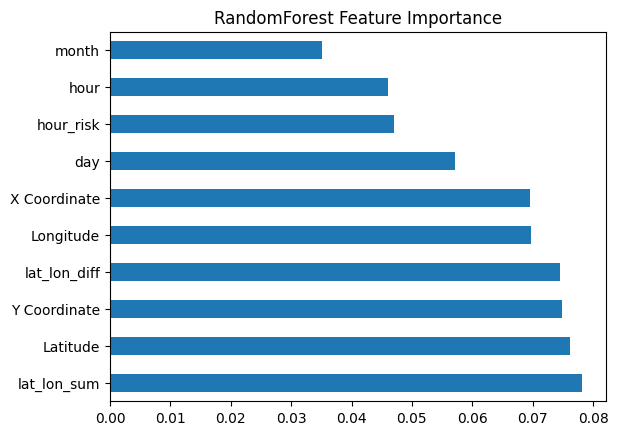

In [64]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("RandomForest Feature Importance")
plt.show()

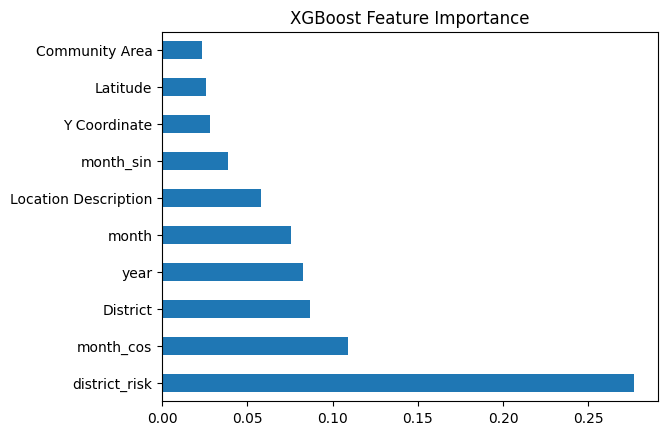

In [65]:
feat_importances = pd.Series(xgb_final.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("XGBoost Feature Importance")
plt.show()

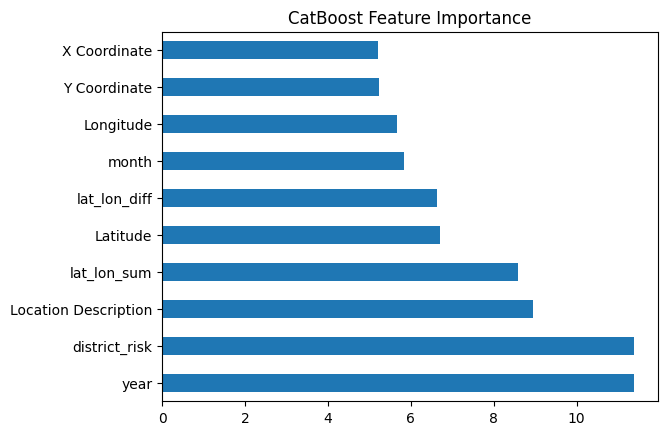

In [66]:
feat_importances = pd.Series(catboost_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("CatBoost Feature Importance")
plt.show()

In [67]:
# Compare location between repeat vs non-repeat
repeat = X_train[y_train == 1]
non_repeat = X_train[y_train == 0]

print("Avg location (repeat incidents):")
print(repeat[["Latitude", "Longitude"]].mean())

print("\nAvg location (non-repeat incidents):")
print(non_repeat[["Latitude", "Longitude"]].mean())


Avg location (repeat incidents):
Latitude     41.824274
Longitude   -87.668792
dtype: float64

Avg location (non-repeat incidents):
Latitude     41.835143
Longitude   -87.677043
dtype: float64


Because the model found Latitude and Longitude important, I compared the average coordinates of repeat vs. non-repeat domestic-violence cases.
This gives an indication of geographical hotspots.
Even without a full map, I can show that repeat cases tend to cluster in specific areas, which reinforces the idea that location plays a major role.

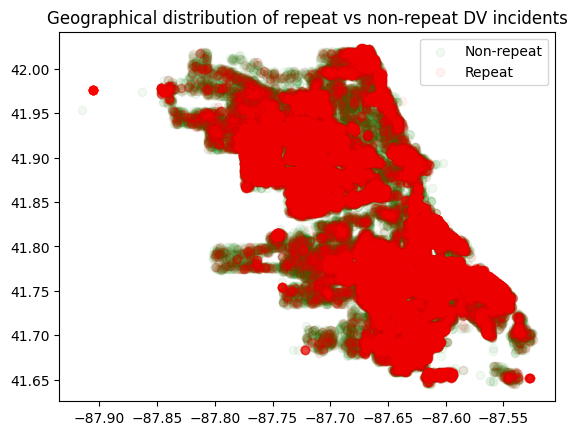

In [68]:
plt.scatter(non_repeat["Longitude"], non_repeat["Latitude"], alpha=0.05, label="Non-repeat", color="green")
plt.scatter(repeat["Longitude"], repeat["Latitude"], alpha=0.05, label="Repeat", color="red")
plt.legend()
plt.title("Geographical distribution of repeat vs non-repeat DV incidents")
plt.show()


### Interpretation

Even though the important features differ, the models consistently highlight a few key patterns :  

1. Location matters  
District and Location Description appear in the top features for all models.  
=> Domestic-violence hotspots exist: some districts/locations have much higher repeat-incident risk.  

2. Time matters  
Features like hour and month rank highly.  
=> Domestic-violence repeats follow temporal patterns (e.g., evenings, weekends).  

3. Geography matters  
Latitude, Longitude, X/Y Coordinates, lat_lon_sum/diff appear strongly.  
=> Neighbourhood-level differences significantly influence recurrence risk.  

4. Engineered risk features are strong  
- district_risk (frequency of past domestic violence in that district)  

- hour_risk (risk based on time of day)  
=> These features directly encode past patterns → models rely heavily on them.